A set of helper methods for streamlining the process of generating images for anthropographics using Stable Diffusion.

# Pipeline setup and prompt generation helpers


In [24]:
import copy
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive

In [25]:
# Populates templates using data from a dataframe and returns either as a new
#  dataframe or as a copy of the original source dataframe with appended columns.
#  Assumes that the column names in the dataframe match the triple-bracketed
#  variables in the templates. Also included dash-concatenated lists of column
#  names and values as a key.
# (See Tests below for a demonstration.)
def generate_prompts_from_dataframe(source_dataframe, template, concat_with_source=True):
  prompt_dataframe = pd.DataFrame(columns=["model_positive_prompt","model_negative_prompt","model_columns","model_key"])
  # get the column names referenced in the the prompts
  pos_columns = re.findall("{{{(\w+)}}}",template["positive"])
  neg_columns = re.findall("{{{(\w+)}}}",template["negative"])

  # for every row in the source_dataframe
  for index, row in source_dataframe.iterrows():
    # create a new copy of the template to update
    temp_template = copy.deepcopy(template)
    key_parts = []
    # populate the template prompts with data from each of the specified columns
    for term in pos_columns:
      temp_template["positive"] = temp_template["positive"].replace("{{{"+term+"}}}",row[term])
      key_parts.append(row[term])
    for term in neg_columns:
      temp_template["negative"] = temp_template["negative"].replace("{{{"+term+"}}}",row[term])
      key_parts.append(row[term])
    # add a row to the new dataframe
    new_row = pd.DataFrame({"model_positive_prompt": temp_template["positive"],
                  "model_negative_prompt":temp_template["negative"],
                  "model_columns": "-".join(pos_columns+neg_columns),
                  "model_key": "-".join(key_parts)},index=[index])
    prompt_dataframe = pd.concat([prompt_dataframe,new_row])
  if concat_with_source:
     prompt_dataframe = pd.concat([source_dataframe,prompt_dataframe],axis=1)
  return prompt_dataframe

In [26]:
# Use the provided pipeline to generate an image for each row in a prompt dataframe.
#  Optionally saves images and a CSV of the dataframe either locally in Colab or GDrive.
def generate_images(pipe, prompt_dataframe, save_to_gdrive=False, save_to_colab=True,
                    gdrive_output_folder="", colab_output_folder="generated_images",
                    positive_prompt_col="model_positive_prompt", negative_prompt_col="model_negative_prompt",
                    key_col="model_key"):

  create_output_folders(save_to_gdrive,save_to_colab,gdrive_output_folder,colab_output_folder)

  print("\nGenerating...\n")
  # Generate and save images
  for index, row in prompt_dataframe.iterrows():
    print(str(index) + ". " + row[key_col])
    result = pipe(row[positive_prompt_col], negative_prompt=row[negative_prompt_col]).images[0]
    display(result)
    if save_to_colab:
      result.save(f'{colab_output_folder}/{row[key_col]}.png')
    if save_to_gdrive:
      result.save(f'{gdrive_output_folder}/{row[key_col]}.png')


In [27]:
# Save a dataframe to CSV, locally on colab and/or GDrive
def save_dataframe(prompt_dataframe, filename="dataframe.csv", save_to_gdrive=False, save_to_colab=True,
                    gdrive_output_folder="", colab_output_folder="generated_images"):

  create_output_folders(save_to_gdrive,save_to_colab,gdrive_output_folder,colab_output_folder)

  if save_to_colab:
    prompt_dataframe.to_csv(colab_output_folder + "/" + filename)
    print("Saved " + colab_output_folder + "/" + filename)
  if save_to_gdrive:
    prompt_dataframe.to_csv(gdrive_output_folder + "/" + filename)
    print("Saved " + gdrive_output_folder + "/" + filename)

In [31]:
# Helper that generates a dataframe containing all combinations of terms from an
#  initial term dictionary.
def generate_term_dataframe_from_dict(term_dict):
  term_combinations = []
  for age in term_dict["ages"]:
    for race in term_dict["races"]:
      for gender in term_dict["genders"]:
        term_combinations.append({"Gender":gender,"Race":race,"Age":age})
  return pd.DataFrame.from_records(term_combinations)

In [28]:
# Helper to create output folders locally on colab and/or GDrive.
def create_output_folders(save_to_gdrive=False, save_to_colab=True,
                    gdrive_output_folder="", colab_output_folder="generated_images"):
  # local spot to save all of the files
  if save_to_colab:
    try:
      os.mkdir(colab_output_folder)
    except FileExistsError as ex:
      pass

  # GDrive to save all of the files
  if save_to_gdrive:
    drive.mount('/content/drive/')
    try:
      os.mkdir(gdrive_output_folder)
    except FileExistsError as ex:
      pass

In [29]:
# Set up a generator pipleline given the provided model
#  and return a reference to the pipeline
def setup_generator_pipeline(model):
  !nvidia-smi
  !pip install diffusers==0.11.1
  !pip install transformers scipy ftfy accelerate

  import torch
  from diffusers import StableDiffusionPipeline

  pipe = StableDiffusionPipeline.from_pretrained(model, torch_dtype=torch.float32, safety_checker = None)

  # Next, let's move the pipeline to GPU to have faster inference.
  pipe = pipe.to("cuda")
  return pipe

# Tests - Generate dataframe with populated prompts

Top-level settings.

In [30]:
MODEL = "SG161222/Realistic_Vision_V1.3"
TEMPLATE = {"positive":"RAW photo, (((centered))) macro head shot photo of a {{{Age}}} year old {{{Race}}} {{{Gender}}} (((white background))),"\
                                                "(((neutral background))), (high detailed skin 1.2), 8k uhd, dslr, soft lighting, high quality,"\
                                                "film grain, Fujifilm XT3, color images, complete face",
                                     "negative":"(cropped, partial face, deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, "\
                                                 "drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, "\
                                                 "jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, "\
                                                 "poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, "\
                                                 "bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, "\
                                                 "malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, "\
                                                 "too many fingers, long neck, nsfw, nude, (((headwear))), (((hat))), monotone, black and white"}
COLAB_OUTPUT_FOLDER = "generated_images"
GDRIVE_OUTPUT_FOLDER = "/content/drive/MyDrive/Priya-Dhawka-Msc /CHI 2024 AI Anthropographics/Images/debug"


Create a simple test dataframe as our source. (Normally we'd load a data file.)

In [32]:
# Create a dataframe with a simple set of 16 combinations and some dummy numbers
demographic_dict = {"genders":["woman", "man"], "races":["Asian", "Black", "Hispanic", "White"], "ages":["30", "60"]}
demographics_df = generate_term_dataframe_from_dict(demographic_dict)
demographics_df['randX'] = np.random.randint(0,100, size=len(demographics_df))
demographics_df['randY'] = np.random.randint(0,100, size=len(demographics_df))
demographics_df.head()

,Gender,Race,Age,randX,randY
0,woman,Asian,30,44,30
1,man,Asian,30,60,30
2,woman,Black,30,39,75
3,man,Black,30,25,54
4,woman,Hispanic,30,76,47


In [33]:
# Generate a set of prompts and keys using these columns
prompts_df = generate_prompts_from_dataframe(demographics_df,TEMPLATE)
prompts_df.head()

,Gender,Race,Age,randX,randY,model_positive_prompt,model_negative_prompt,model_columns,model_key
0,woman,Asian,30,44,30,"RAW photo, (((centered))) macro head shot phot...","(cropped, partial face, deformed iris, deforme...",Age-Race-Gender,30-Asian-woman
1,man,Asian,30,60,30,"RAW photo, (((centered))) macro head shot phot...","(cropped, partial face, deformed iris, deforme...",Age-Race-Gender,30-Asian-man
2,woman,Black,30,39,75,"RAW photo, (((centered))) macro head shot phot...","(cropped, partial face, deformed iris, deforme...",Age-Race-Gender,30-Black-woman
3,man,Black,30,25,54,"RAW photo, (((centered))) macro head shot phot...","(cropped, partial face, deformed iris, deforme...",Age-Race-Gender,30-Black-man
4,woman,Hispanic,30,76,47,"RAW photo, (((centered))) macro head shot phot...","(cropped, partial face, deformed iris, deforme...",Age-Race-Gender,30-Hispanic-woman


# Tests - Load and test Stable Diffusion pipeline

Set up a test pipeline

In [34]:
#setup
pipe = setup_generator_pipeline(MODEL)

Sun Jul 23 05:02:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

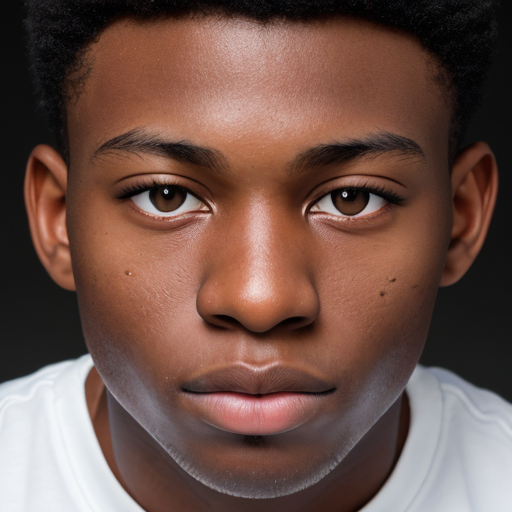

In [35]:
# Test pipeline a simple prompt
prompts = ["RAW photo, (((centered))) macro head shot photo of a Black 20 year old man, (((white background))), high detailed skin 1.2), 8k uhd, dslr, soft lighting, high quality, film frain, Fujifilm XT3, color images"]
pipe(prompts).images[0]


# Tests - Generate images


In [36]:
# save out the entire dataframe
save_dataframe(prompts_df,"dataframe.csv",True, True, GDRIVE_OUTPUT_FOLDER)

Mounted at /content/drive/
Saved generated_images/dataframe.csv
Saved /content/drive/MyDrive/Priya-Dhawka-Msc /CHI 2024 AI Anthropographics/Images/debug/dataframe.csv


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Generating...

0. 30-Asian-woman


  0%|          | 0/50 [00:00<?, ?it/s]

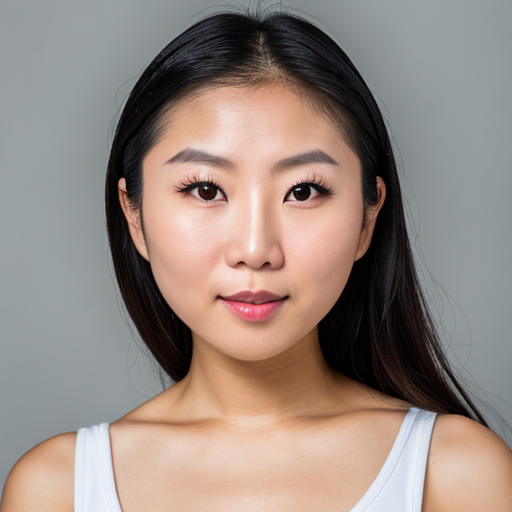

1. 30-Asian-man


  0%|          | 0/50 [00:00<?, ?it/s]

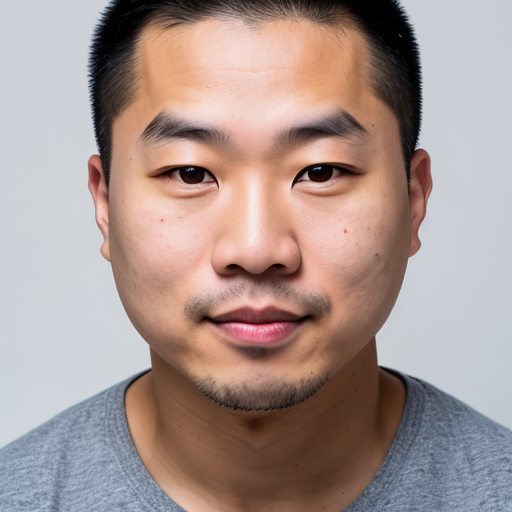

2. 30-Black-woman


  0%|          | 0/50 [00:00<?, ?it/s]

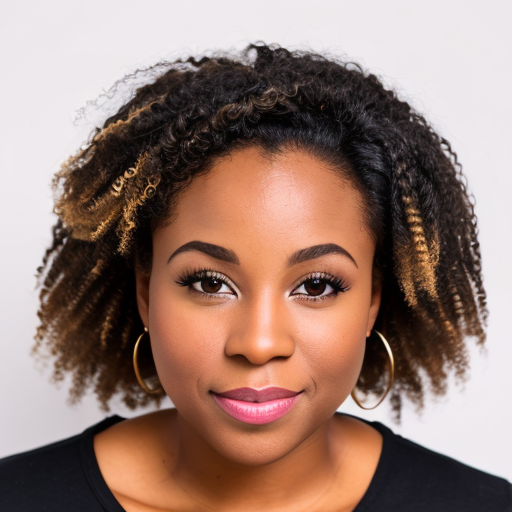

3. 30-Black-man


  0%|          | 0/50 [00:00<?, ?it/s]

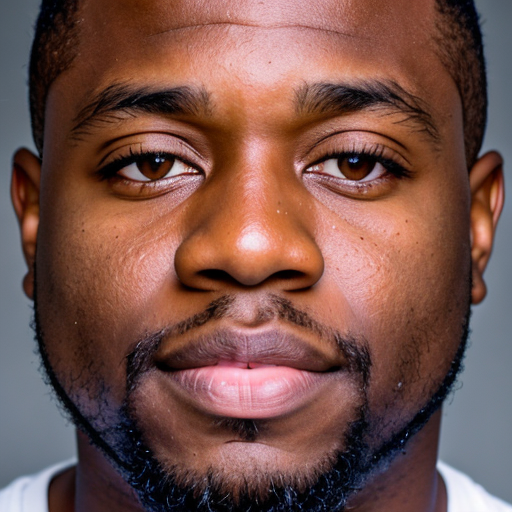

In [37]:
# generate images for the first four rows in the dataframe
generate_images(pipe, prompts_df[:4], True, True, GDRIVE_OUTPUT_FOLDER)

In [ ]:
# If outputting locally to Colab, you can also create a zip of the whole
#  generated_images folder that can then be downloaded all at once.
import shutil
shutil.make_archive("COLAB_OUTPUT_FOLDER", "zip", "generated_images")

'/content/generated_images.zip'